In [1]:
import re
import time
import numpy
import pandas as pd

from bs4 import BeautifulSoup
from selenium import webdriver
from tqdm import tqdm

from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import Chrome

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Парсинг комментариев и имен пользователей

In [2]:
#Создаем списки для результатов парсинга
scrapped = []
scrapped2 = []
with webdriver.Chrome(executable_path = r'C:\temp\chromedriver.exe') as driver: #Инициализируем экземпляр webdriver
    #Указываем время ожидания в секундах и URL обзора матчей
    wait = webdriver.support.ui.WebDriverWait(driver, 1)
    driver.get("https://www.sports.ru/hockey/1115007425-nxl-boston-primet-tampu-rejndzhers-v-gostyax-u-floridy-pittsburg-proti.html")
    for item in tqdm(range(30)): #Задаем количество прокруток для загрузки комментариев
        wait.until(webdriver.support.expected_conditions.visibility_of_element_located(
            (By.TAG_NAME, 'body'))).send_keys(webdriver.common.keys.Keys.END)
        time.sleep(4) #Указываем время ожидания в секундах после каждой прокрутки

    for nikcname in wait.until(webdriver.support.expected_conditions.presence_of_all_elements_located(
        (By.CLASS_NAME, "comment-author__nick"))): #Получаем имена пользователей по названию класса "comment-author__nick"
        scrapped.append(nikcname.text) #Добавляем имена пользователей в список
        
    for comment in wait.until(webdriver.support.expected_conditions.presence_of_all_elements_located(
        (By.CLASS_NAME, "comment-content"))): #Получаем комментарии по названию класса "comment-content"
        scrapped2.append(comment.text) #Добавляем тексты комментариев в список

comments = scrapped2
nicknames = scrapped

C:\Users\79133\AppData\Local\Temp\ipykernel_9920\1242457234.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  with webdriver.Chrome(executable_path = r'C:\temp\chromedriver.exe') as driver: #Инициализируем экземпляр webdriver
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:05<00:00,  4.17s/it]


## Подсчет комментариев, оставленных пользователями

In [3]:
if(len(comments)!=len(nicknames)): #Проверяем корректность парсинга
    print("Ошибка при парсинге!")
else:
    ccount = [] #Создаем список для подсчета комментариев, оставленных отдельным пользователем
    for i in range (len(nicknames)): #Считаем сами комментарии
        count = 0
        for j in range (len(nicknames)):
            if (nicknames[i] == nicknames[j]):
                count+=1
        ccount.append(count)
#Создаем словарь, в котором ключ - имя пользователя, а значение - количество комментариев, оставленных пользователем
slovnicknames = {} 
for i in range(len(nicknames)):
    slovnicknames[nicknames[i]] = ccount[i]

### Создание таблицы комментариев

In [4]:
comments_df = pd.DataFrame({'comment':comments})
comments_df

,comment
0,"Сегодня не стареющая классика "" Питтсбург "" - ..."
1,Забыл добавить по передачам и очкам (ну овигло...
2,"Овечкин забил не 37, а 38 шайб ""Питтсбургу"", 2..."
3,"Мысли вслух:\nБостон уже давно первый, Каролин..."
4,Кошки должны быть в плей-офф. За ̶д̶е̶р̶ж̶а̶в̶...
...,...
414,Бегунка наказали...
415,Невезуха
416,хейтерок💪😬
417,Витек пушка! Гаси мишек.


# Очиста текста комментариев от лишних символов

### Функция очистки

In [5]:
def clear_text(text:str) -> str:
    """
    Функция получает на вход строчку текста

    Удаляет с помощью регулярного выражения
    все не кириллические символы и приводит
    слова к нижнему регистру

    Возвращает обработанную строчку
    """
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return ' '.join(clear_text.split())

### Определение слов, не влияющих на оценку комментария

In [6]:
stopwords = set(nltk_stopwords.words('russian'))
numpy.array(stopwords)

array({'в', 'будто', 'тоже', 'во', 'через', 'три', 'ей', 'меня', 'нее', 'что', 'никогда', 'даже', 'него', 'он', 'надо', 'всего', 'не', 'без', 'впрочем', 'и', 'мне', 'может', 'ни', 'много', 'ним', 'кто', 'я', 'о', 'чтобы', 'ну', 'теперь', 'тот', 'конечно', 'уже', 'нибудь', 'за', 'до', 'чтоб', 'этот', 'от', 'сам', 'зачем', 'можно', 'хоть', 'будет', 'ж', 'ее', 'для', 'этой', 'всю', 'его', 'да', 'где', 'чего', 'том', 'тем', 'больше', 'вам', 'если', 'ней', 'нас', 'себе', 'куда', 'всех', 'еще', 'себя', 'всегда', 'мы', 'ему', 'есть', 'того', 'как', 'эти', 'потом', 'ничего', 'или', 'здесь', 'хорошо', 'тут', 'а', 'почти', 'из', 'этом', 'про', 'по', 'было', 'под', 'опять', 'моя', 'их', 'более', 'так', 'тебя', 'вдруг', 'этого', 'бы', 'после', 'были', 'но', 'об', 'вас', 'один', 'быть', 'эту', 'уж', 'с', 'тогда', 'другой', 'разве', 'такой', 'к', 'потому', 'между', 'ли', 'был', 'какой', 'два', 'им', 'на', 'ты', 'какая', 'вы', 'совсем', 'раз', 'когда', 'они', 'ведь', 'то', 'же', 'при', 'со', 'только'

### Функция удаления этих слов

In [7]:
def clean_stopwords(text:str, stopwords:list):
    """
    Функция получает:
    * text -- строчку текста
    * stopwords -- список слов для исключения из текста

    Возвращает строчку текста с исключенными стоп словами

    """
    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)

### Очистка текста комментариев

In [8]:
start_clean = time.time()

comments_df['text_clear'] = comments_df['comment'].apply(lambda x: clean_stopwords(clear_text(str(x)), stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 0.03 секунд


### Вывод измененных комментариев

In [9]:
comments_df

,comment,text_clear
0,"Сегодня не стареющая классика "" Питтсбург "" - ...",сегодня стареющая классика питтсбург вашингтон...
1,Забыл добавить по передачам и очкам (ну овигло...,забыл добавить передачам очкам овиглору интере...
2,"Овечкин забил не 37, а 38 шайб ""Питтсбургу"", 2...",овечкин забил шайб питтсбургу гостях дома соот...
3,"Мысли вслух:\nБостон уже давно первый, Каролин...",мысли вслух бостон давно первый каролина вероя...
4,Кошки должны быть в плей-офф. За ̶д̶е̶р̶ж̶а̶в̶...,кошки должны плей офф д е р дивизион обидно
...,...,...
414,Бегунка наказали...,бегунка наказали
415,Невезуха,невезуха
416,хейтерок💪😬,хейтерок
417,Витек пушка! Гаси мишек.,витек пушка гаси мишек


# Визуализация частотности слов

In [10]:
comments_counter = CountVectorizer(ngram_range=(1,1)) #Для корпуса текстов инциализируем экземпляр класса

#Получаем словарь уникальных слов (fit) и сразу же считаем частотность для текста (transform)
comments_count = comments_counter.fit_transform(comments_df['text_clear'])

#Получаем словарь из CountVectorizer c помощью .get_feature_names_out()
#Получаем частотность слов находя сумму компонент векторов
comments_frequence = pd.DataFrame({'word' : comments_counter.get_feature_names_out(), 'frequency' : numpy.array(comments_count.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)

#Оставляем 100 наиболее частотных
comments_frequence_filtered = comments_frequence[:100]

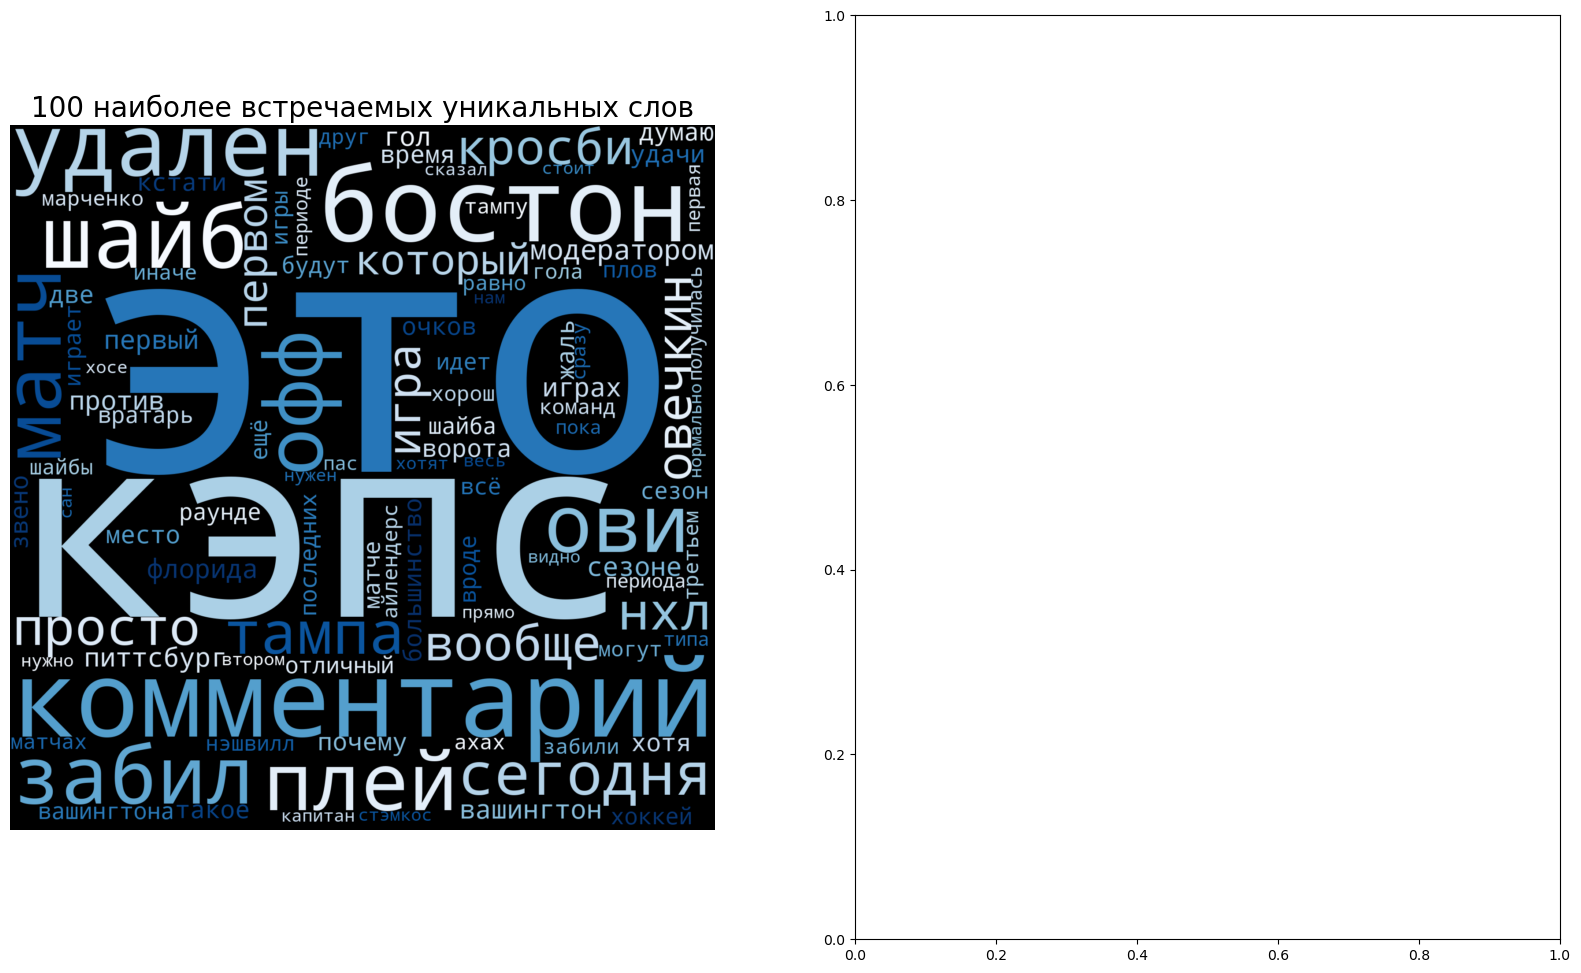

In [11]:
#Генерируем картинки со словами на которых размер шрифта соответствует частотности
wordcloud_comments = WordCloud(background_color="black", colormap = 'Blues', max_words=200, mask=None, width=1600,height=1600).generate_from_frequencies(dict(comments_frequence_filtered.values))

#Выводим картинки сгенерированные вордклаудом с помощью matplotlib.pyplot
fig, ax = plt.subplots(1,2, figsize = (20, 12))
ax[0].imshow(wordcloud_comments, interpolation='bilinear')
ax[0].set_title('100 наиболее встречаемых уникальных слов', fontsize = 20)
ax[0].axis("off")
plt.show()

# Загрузка размеченного датасета study.mokoron и его очистка

In [12]:
positive = pd.read_csv(r'C:\temp\positive.csv', sep = ';', header= None)
negative = pd.read_csv(r'C:\temp\negative.csv', sep = ';', header= None)
positive_text = pd.DataFrame(positive.iloc[:, 3])
negative_text = pd.DataFrame(negative.iloc[:, 3])
positive_text['label'] = [1] * positive_text.shape[0]
negative_text['label'] = [0] * negative_text.shape[0]
labeled_tweets = pd.concat([positive_text, negative_text])
labeled_tweets.index = range(labeled_tweets.shape[0])

### Вывод без очистки

In [13]:
labeled_tweets.columns = ['text', 'label']
labeled_tweets

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1
...,...,...
226829,Но не каждый хочет что то исправлять:( http://...,0
226830,скучаю так :-( только @taaannyaaa вправляет мо...,0
226831,"Вот и в школу, в говно это идти уже надо(",0
226832,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0


### Очистка 

In [14]:
start_clean = time.time()

labeled_tweets['text_clear'] = labeled_tweets['text'].apply(lambda x: clean_stopwords(clear_text(str(x)), stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 4.16 секунд


In [15]:
labeled_tweets = labeled_tweets[['text_clear', 'label']]
labeled_tweets

,text_clear,label
0,школота поверь самое общество профилирующий пр...,1
1,таки немного похож мальчик равно,1
2,идиотка испугалась,1
3,углу сидит погибает голода ещё порции взяли хо...,1
4,значит страшилка блин посмотрев части создастс...,1
...,...,...
226829,каждый хочет исправлять,0
226830,скучаю вправляет мозги равно скучаю,0
226831,школу говно это идти,0
226832,тауриэль грусти обнял,0


# Расчёт векторного представления для комментариев

Для обучения классификатора получим значения IDF (inference document frequency) для слов из тренировочного набора данных, значения IDF равны логарифму отношения количества документов к количеству документов содержащих искомое слово. Например для стандартных слов, которые встречаются практически в любом тексте IDF будет близок к единице, а для специфичных, которые встречаются в одном тексте из 100 это значение будет равно уже 2 (если мы берем основание логарифма 10).

Затем получив словарь со значениями IDF мы можем получить векторное представление каждого текста по следующему принципу, значения IDF слова умножаем на значения.

Напишем код расчёта векторного представления для комментариев, не забыв предварительно разделить выборку на обучающую и тестовую в пропорции 4 к 1. Ведь если мы начнем считать статистики слов используя полный корпус текстов то не сможем потом проверить, как себя будет вести классификатор встретившись с незнакомыми текстами.

In [16]:
#Предварительно разделим выборку на тестовую и обучающую
train, test = train_test_split(labeled_tweets, test_size = 0.2, stratify = labeled_tweets['label'],random_state = 12348,)

#Инцициализируем векторайзер и укажем размер n-грамм
counter_idf = TfidfVectorizer(ngram_range=(1,1))

#Получаем словарь и idf только из тренировочного набора данных
count_train = counter_idf.fit_transform(train['text_clear'])

#Применяем обученный векторайзер к тестовому набору данных
count_test = counter_idf.transform(test['text_clear'])

#Инициализируем модель с параметрами по умолчанию
model_lr = LogisticRegression(random_state = 12345,max_iter = 10000,n_jobs = -1)

#Подбираем веса для слов с помощь fit на тренировочном наборе данных
model_lr.fit(count_train, train['label'])

#Получаем прогноз модели на тестовом наборе данных
predict_count_proba = model_lr.predict_proba(count_test)

# Визуализация важности признаков

In [17]:
#Объединим в таблицу словарь из нашего векторайзера и веса для слов из обученной модели
weights = pd.DataFrame({'words': counter_idf.get_feature_names_out(), 'weights': model_lr.coef_.flatten()})

#Создаем копию отсортированную по возрастанию
weights_min = weights.sort_values(by= 'weights')

#И еще одну отсортированную по убыванию
weights_max = weights.sort_values(by= 'weights', ascending = False)

## Определение слов с отрицательным весом

In [18]:
weights_min = weights_min[:100]
weights_min['weights'] = weights_min['weights'] * -1
weights_min

,words,weights
74717,обидно,7.209690
86447,печально,5.951431
34130,жаль,5.900135
25305,грустно,5.860879
116106,скучаю,5.513762
...,...,...
31254,достали,2.564749
101808,пропало,2.562823
117042,слёзы,2.550882
68734,настроения,2.543243


## Определение слов с положительным весом 

In [19]:
weights_max = weights_max[:100]
weights_max

,words,weights
4756,ахахах,4.727178
4723,ахах,4.466665
4724,ахаха,4.464142
18241,вромайдан,4.118346
100080,приятно,4.083259
...,...,...
79249,оси,2.046992
95006,посмотрите,2.038521
123769,супер,2.028916
100082,приятного,2.027588


## Визуализация 

In [20]:
wordcloud_positive = WordCloud(background_color="white", colormap = 'Blues', max_words=200, mask=None, width=1600, height=1600).generate_from_frequencies(dict(weights_max.values))

wordcloud_negative = WordCloud(background_color="black", colormap = 'Reds', max_words=200, mask=None, width=1600, height=1600).generate_from_frequencies(dict(weights_min.values))

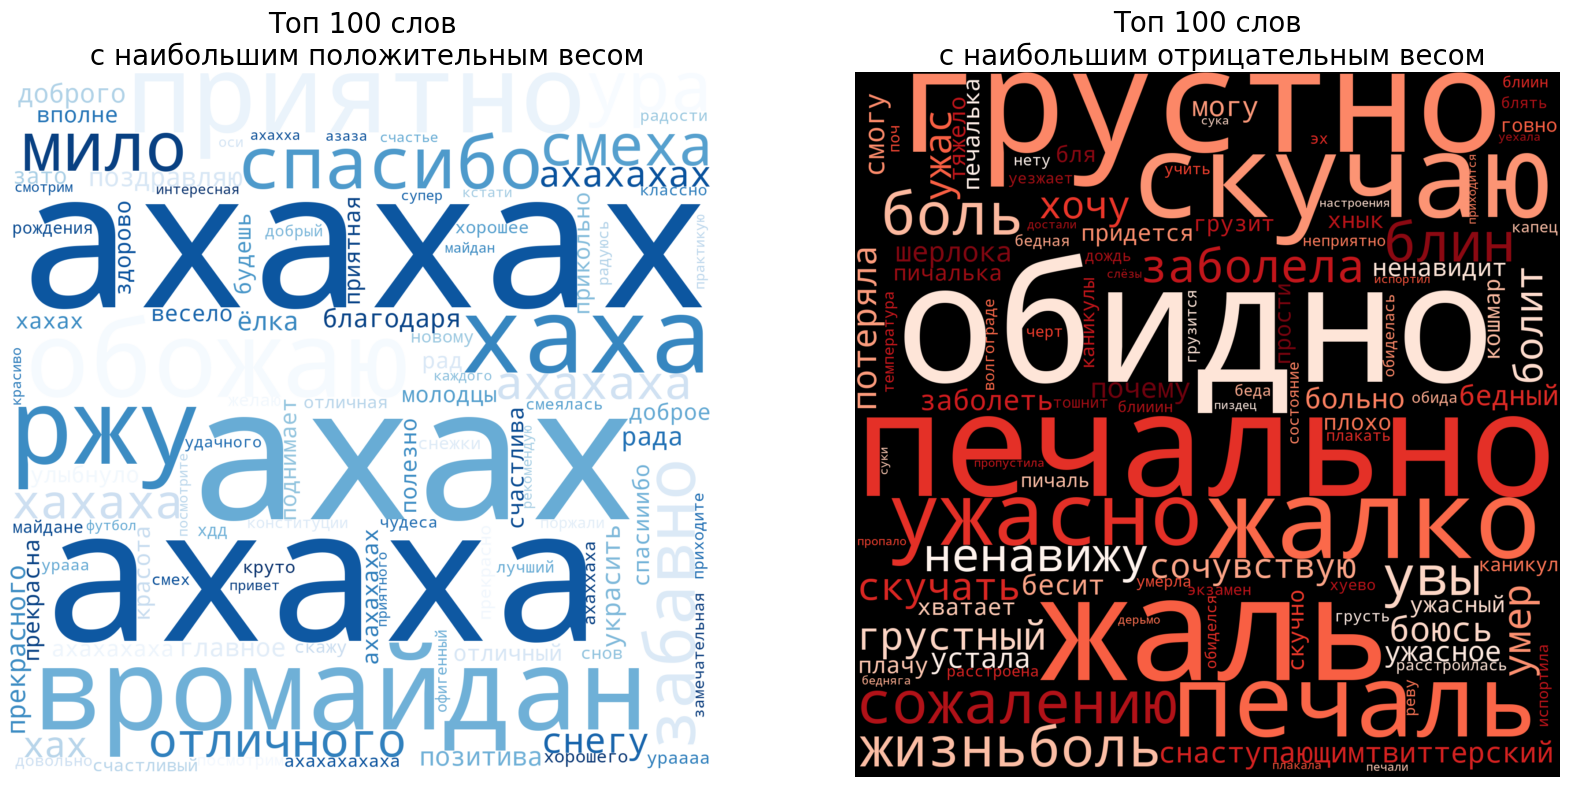

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (20, 12))


ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[1].imshow(wordcloud_negative, interpolation='bilinear')

ax[0].set_title('Топ ' +\
                str(weights_max.shape[0]) +\
                ' слов\n с наибольшим положительным весом',
               fontsize = 20
               )
ax[1].set_title('Топ ' +\
                str(weights_min.shape[0]) +\
                ' слов\n с наибольшим отрицательным весом',
               fontsize = 20
               )

ax[0].axis("off")
ax[1].axis("off")

plt.show()

# Классификация неразмеченных комментариев

### Определение вероятности негативности текста комментария

Переводим комментарии в вектора с помощью обученного векторайзера и подаем числа в обученную модель, получая вероятность негатива:

In [22]:
tox = []
for i in range(len(comments)):

    source = comments_df.iloc[i:i+1,0:2]
    text_clear = source['text_clear'].values[0]
    text = source['comment'].values[0]



    tf_idf_text = counter_idf.transform([text_clear])

    toxic_proba = model_lr.predict_proba(tf_idf_text)

    tox.append(toxic_proba[:,0])


### Классификация комментариев по вероятности негатива

In [23]:
occom = [] #Создаем список для оценки комментариев
for i in range (len(tox)):
    if (tox[i] < 0.5): #Комментарии с вероятностью негативности меньше 0,5 отмечаем как положительные
        occom.append(1)
    if (tox[i]>=0.5 and tox[i]<0.6): #Комментарии с вероятностью негативности больше 0,5, но меньше 0,6 отмечаем как нейтральные
        occom.append(0)
    if (tox[i]>=0.6): #Комментарии с вероятностью негативности больше 0,6 отмечаем как негативные
        occom.append(-1)

### Подсчет комментариев по классификации

In [24]:
ccountp = [] #Список положительных комментариев, оставленных пользователем
ccountneg = [] #Список негативных комментариев, оставленных пользователем
ccountneu = [] #Список нейтральных комментариев, оставленных пользователем
for i in range (len(nicknames)): #Считаем положительные комментарии
    countp = 0
    for j in range (len(nicknames)):
        if (nicknames[i] == nicknames[j]): 
            if (1 == occom[j]):
                countp+=1
    ccountp.append(countp)
for i in range (len(nicknames)): #Считаем негативные комментарии
    countneg = 0
    for j in range (len(nicknames)):
        if (nicknames[i] == nicknames[j]):
            if (-1 == occom[j]):
                countneg += 1
    ccountneg.append(countneg)
for i in range (len(nicknames)): #Считаем нейтральные комментарии
    countneu = 0
    for j in range (len(nicknames)):
        if (nicknames[i] == nicknames[j]):
            if (0 == occom[j]):
                countneu += 1
    ccountneu.append(countneu)

polslov = {} #Создаем словарь, в котором ключ - имя пользователя, значение - количество положительных комментариев
for i in range(len(nicknames)):
    polslov[nicknames[i]] = ccountp[i]
negslov = {} #Создаем словарь, в котором ключ - имя пользователя, значение - количество негативных комментариев
for i in range(len(nicknames)):
    negslov[nicknames[i]] = ccountneg[i]
neuslov = {} #Создаем словарь, в котором ключ - имя пользователя, значение - количество нейтральных комментариев
for i in range(len(nicknames)):
    neuslov[nicknames[i]] = ccountneu[i]

# Таблица, отражающая классификацию комментариев

In [25]:
#Убираем ограничение для вывода полной таблицы
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#Создаем таблицу
finallytable = pd.DataFrame({'Имя пользователя':slovnicknames.keys(),'Количество комментариев':slovnicknames.values(),'Количество положительных комментариев':polslov.values(),'Количество негативных комментариев':negslov.values(),'Количество нейтральных комментариев':neuslov.values()})
#И сортируем её по количеству комментариев, оставленных пользователем
finallytable.sort_values(by='Количество комментариев',ascending=False)

,Имя пользователя,Количество комментариев,Количество положительных комментариев,Количество негативных комментариев,Количество нейтральных комментариев
20,hhlg,47,34,5,8
5,e1ther - e1ther,33,25,6,2
35,ИваннИванов,32,22,3,7
2,Барин,30,23,4,3
22,Фанат Ференцвароша,18,15,2,1
24,CLB_82,15,13,1,1
56,Юрий Богданов,13,13,0,0
19,Беня_Финитас,10,7,3,0
33,ЭХ,10,7,3,0
32,Максим Яблонский,9,7,1,1


# Вывод классификации комментариев и самих комментариев, оставленных отдельно взятым пользователем

In [26]:
username = input("Введите имя пользователя: ")
if username in slovnicknames: #Выполняем, если имя пользователя есть в словаре
    print("Количество оставленных коментариев: ", slovnicknames[username])
    print("Количество положительных комментариев: ", polslov[username])
    print("Количество негативных комментариев: ", negslov[username])
    print("Количество нейтральных комментариев: ", neuslov[username])
    print()
    for i in range(len (nicknames)):
        if username == nicknames[i]:
            if occom[i] == 1:
                print("Положительный комментарий: ")
            elif occom[i] == -1:
                print("Негативный комментарий: ")
            else:
                print("Нейтральный комментарий: ")
            print(comments[i])
            print()
                
else:
    print("Нет пользователя с таким именем")

Введите имя пользователя: Кагов
Количество оставленных коментариев:  4
Количество положительных комментариев:  3
Количество негативных комментариев:  0
Количество нейтральных комментариев:  1

Положительный комментарий: 
Желаю, чтобы все наши сегодня пополнили свой счёт.
Ну а Кросби и так пополнит. Кажется им ещё раз 36 с Ови сыграть придётся! На двоих у них 148 очков за 64 игры. Другой такой пары противостояний кажется нет в НХЛ, чтобы неизменно играли за одну и ту же свою команду По матчам может быть и есть, у Хоу например, а вот по очкам вряд ли.

Положительный комментарий: 
Кросби и Овечкин сыграют 65 раз друг против друга в НХЛ.
В 64 играх Кросби набрал 86 ( 28+58 )
Овечкин 62 ( 33+29 )
Питтсбург в этих матчах 37-23-4
Вашингтон 27-30-7
У Малкина 72 ( 24+48 ) в 57 играх против Вашингтона.
(Скопировал, чтоб не потерялось)

Нейтральный комментарий: 
Ждём гостевого гола Ови и домашнего гола Джино.
Ну и очков Кросби. Ови, думаю, поздравит его после матча.

Положительный комментарий: 
И

# Анализ тональности текстов комментариев

In [44]:
#Получим вектора tf-idf
comments_tf_idf = counter_idf.transform(comments_df['text_clear'])

#Получим прогноз негативности комментария
comments_negative_proba = model_lr.predict_proba(comments_tf_idf)

#Добавим прогнозы в таблицу
comments_df['negative_proba'] = comments_negative_proba[:, 0]

#Посчитаем доли негативных комментариев при подобранном пороговом значении
comments_share_negative = (comments_df['negative_proba'] >= 0.6).sum()/ comments_df.shape[0]

#Отобразим полученные данные в виде графиков скрипичных диаграмм

fig = make_subplots(1,1, subplot_titles=['Распределение комментариев по оценке негативности'])

fig.add_trace(go.Violin(x = comments_df['negative_proba'],meanline_visible = True, name = 'Comments (N = %i)' % comments_df.shape[0],side = 'positive',spanmode = 'hard'))





fig.add_annotation(x=0.8, y=0.5,text = "%0.2f — доля негативных комментариев (при p >= 0.6)"% comments_share_negative,showarrow=False,yshift=10)

fig.update_traces(orientation='h', width = 1.5,points = False)

fig.update_layout(height = 500,xaxis_zeroline=False,template = 'simple_white',font_color = 'rgba(0, 0, 0, 250)',legend=dict(y=0.9,x=-0.1,yanchor='top',),)
fig.update_yaxes(visible = False)         


fig.show()